In [30]:
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)

In [31]:
class Backpropagation:
    def _init_(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.weights_input_hidden = np.random.randn(self.input_size, self.hidden_size)
        self.weights_hidden_output = np.random.randn(self.hidden_size, self.output_size)

        self.bias_hidden = np.zeros((1, self.hidden_size))
        self.bias_output = np.zeros((1, self.output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def feedforward(self, X):
        self.hidden_activation = np.dot(X, self.weights_input_hidden) + self.bias_hidden
        self.hidden_output = self.sigmoid(self.hidden_activation)

        self.output_activation = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_output
        self.predicted_output = self.sigmoid(self.output_activation)

        return self.predicted_output

    def backward(self, X, y, learning_rate):
        output_error = y - self.predicted_output
        output_delta = output_error * self.sigmoid_derivative(self.predicted_output)

        hidden_error = np.dot(output_delta, self.weights_hidden_output.T)
        hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_output)

        self.weights_hidden_output += np.dot(self.hidden_output.T, output_delta) * learning_rate
        self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate
        self.weights_input_hidden += np.dot(X.T, hidden_delta) * learning_rate
        self.bias_hidden += np.sum(hidden_delta, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.feedforward(X)
            self.backward(X, y, learning_rate)
            if epoch % 4000 == 0:
                loss = np.mean(np.square(y - output))
                print(f"Epoch {epoch}, Loss:{loss}")

In [32]:
df = pd.read_csv('obesity-dataset-preprocessed.csv')
df.shape

(2063, 21)

Epoch 0, Loss:0.20114532074483418
Epoch 4000, Loss:0.03463690385947813
Epoch 8000, Loss:0.03352553990454882
Epoch 12000, Loss:0.032909321219228634
Epoch 16000, Loss:0.03221796102219358
Fold Accuracy: 0.9353164994811484
              precision    recall  f1-score   support

           0       0.60      0.91      0.73        54
           1       0.67      0.49      0.57        57
           2       0.78      0.76      0.77        70
           3       0.82      0.83      0.82        59
           4       0.88      0.95      0.91        60
           5       0.69      0.64      0.66        55
           6       0.78      0.62      0.69        58

    accuracy                           0.74       413
   macro avg       0.74      0.74      0.74       413
weighted avg       0.75      0.74      0.74       413

Epoch 0, Loss:0.2896087984141665
Epoch 4000, Loss:0.036049708084777164
Epoch 8000, Loss:0.034966786276838094
Epoch 12000, Loss:0.03447717998753339
Epoch 16000, Loss:0.03411879132799008

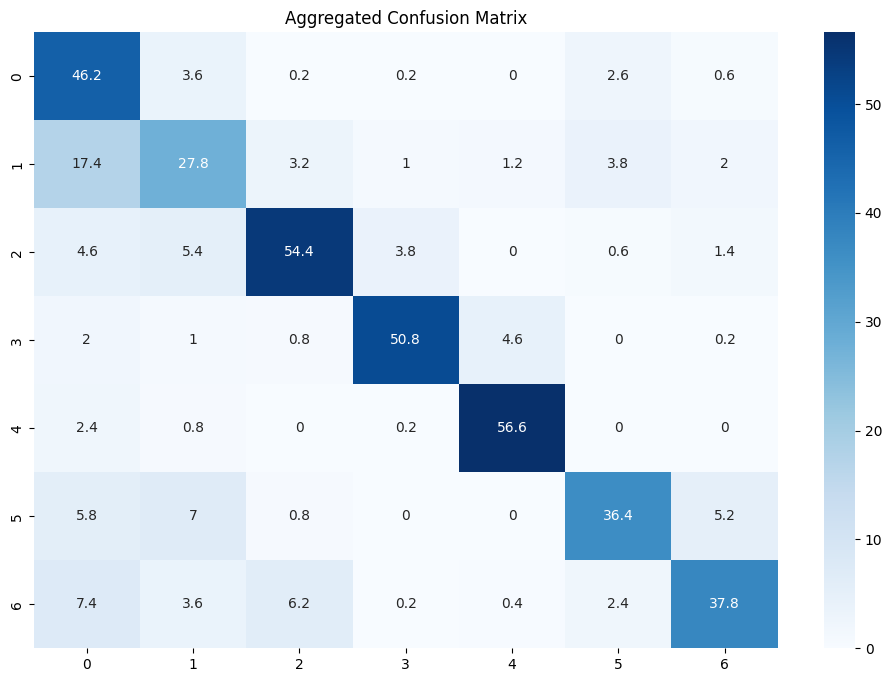

In [33]:
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Assuming `df` is the dataframe with your dataset
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Convert labels to one-hot encoding
y_one_hot = pd.get_dummies(y).to_numpy()

# Convert features to numpy
X = X.to_numpy()

# Initialize cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Model parameters
input_size = X.shape[1]
hidden_size = 10
output_size = y_one_hot.shape[1]

# Placeholder for overall metrics
accuracies = []
classification_reports = []
confusion_matrices = []

# Cross-validation loop
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    # Initialize and train the neural network
    nn = Backpropagation()
    nn._init_(input_size, hidden_size, output_size)
    nn.train(X_train, y_train, 20000, 0.01)

    # Generate predictions
    output = nn.feedforward(X_test)
    output = np.round(output)

    # Calculate accuracy
    accuracy = np.mean(output == y_test)
    accuracies.append(accuracy)

    # Store classification report and confusion matrix
    classification_reports.append(classification_report(y_test.argmax(axis=1), output.argmax(axis=1), output_dict=True))
    confusion_matrices.append(confusion_matrix(y_test.argmax(axis=1), output.argmax(axis=1)))

    print(f"Fold Accuracy: {accuracy}")
    print(classification_report(y_test.argmax(axis=1), output.argmax(axis=1)))

# Average accuracy across folds
print(f"Average Accuracy: {np.mean(accuracies)}")

# Aggregate confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot aggregated confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(average_cm, annot=True, fmt='g', cmap='Blues')
plt.title("Aggregated Confusion Matrix")
plt.show()
